# Defining the Network

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import itertools

In [23]:
def create_network(N, M, rate_constants, p, e):
    species = [f"A{i+1}" for i in range(N)]
    reactions = []

    for alpha in range(M):
        is_bimolecular = random.random() < p

        if is_bimolecular:
            reaction_species = random.sample(species, 4)
            reactants = reaction_species[:2]
            products = reaction_species[2:]
        else:
            reaction_species = random.sample(species, 2)
            reactants = reaction_species[:1]
            products = reaction_species[1:]
        
        reaction_species = set(reactants + products)
        
        catalyzed = random.random() < e
        if catalyzed:
            catalyst = random.sample(list(set(species) - reaction_species),1)[0]
            reactants.append(catalyst)
            products.append(catalyst)
        
        k_alpha = random.choice(rate_constants)

        reaction = {
            'reaction_id': alpha,
            'reactants': reactants,
            'products': products,
            'rate_constant': k_alpha
        }
        reactions.append(reaction)
    return species, reactions

def get_reaction_table(reactions):
    reaction_data = []
    for reaction in reactions:
        # Format the reaction data into a row for the table
        reaction_id = reaction['reaction_id']
        reactants = ' + '.join(reaction['reactants'])  # Join reactants as a string
        products = ' + '.join(reaction['products'])    # Join products as a string
        rate_constant = reaction['rate_constant']
        
        # Add row to the reaction data list
        reaction_data.append([reaction_id, reactants, products, rate_constant])

    # Print the table
    headers = ["Reaction ID", "Reactants", "Products", "Rate Constant"]
    print(tabulate(reaction_data, headers=headers, tablefmt="pretty"))

In [24]:
N = 25 # Number of species
M = 35 # Number of reactions
p = 0.3
e = 0.5
rate_constants = [1, 1e-1, 1e-2, 1e-3]

species, reactions = create_network(N, M, rate_constants, p, e)
get_reaction_table(reactions)

+-------------+-----------------+----------------+---------------+
| Reaction ID |    Reactants    |    Products    | Rate Constant |
+-------------+-----------------+----------------+---------------+
|      0      |     A2 + A4     |   A16 + A11    |     0.001     |
|      1      |    A7 + A10     |   A17 + A10    |     0.01      |
|      2      |    A1 + A20     |   A10 + A20    |      0.1      |
|      3      |       A9        |      A22       |     0.01      |
|      4      |    A7 + A22     |   A21 + A22    |       1       |
|      5      |     A8 + A4     |    A19 + A4    |       1       |
|      6      |    A19 + A13    |   A16 + A20    |     0.001     |
|      7      |     A5 + A9     |    A24 + A9    |      0.1      |
|      8      | A19 + A17 + A10 | A1 + A5 + A10  |     0.001     |
|      9      |       A9        |       A4       |       1       |
|     10      |    A15 + A13    |   A16 + A13    |     0.01      |
|     11      |    A5 + A15     |    A1 + A4     |     0.01   

# Gillespie Step

In [25]:
def gillespie_step(concentrations, reactions):
    total_propensity = 0
    propensities = []

    for reaction in reactions:
        propensity = reaction['rate_constant']
        for reactant in reaction['reactants']:
            propensity *= concentrations[reactant]
        propensities.append(propensity)
        total_propensity += propensity
    
    if total_propensity == 0:
        return None, None, None
    
    time_step = np.random.exponential(1/total_propensity)
    random_value = np.random.random() * total_propensity
    cumulative_propensity = 0
    reaction_index = -1
    for i, propensity in enumerate(propensities):
        cumulative_propensity += propensity
        if cumulative_propensity >= random_value:
            reaction_index = i
            break
    
    reaction = reactions[reaction_index]
    for reactant in reaction['reactants']:
        concentrations[reactant] -= 1 # reactant is consumed
        # if concentrations[reactant] == 0:
        #     concentrations[reactant] = 1 # prevent negative concentrations
    
    for product in reaction['products']:
        concentrations[product] += 1 # product is produced
    
    return time_step, reaction, concentrations

In [26]:
def fetch_analytical_details(concentrations):
    print("Number of species : ", len(concentrations))
    # Find the maximum concentration of species
    max_conc = max(concentrations.values())

    # Find which species has the maximum concentration
    max_conc_species = [s for s in species if concentrations[s] == max_conc]

    # Find the minimum non-zero concentration of species
    min_conc = min([c for c in concentrations.values()])

    # Find which species has the minimum non-zero concentration
    min_conc_species = [s for s in species if concentrations[s] == min_conc]
    print("Number of species at minimum concentration :", len(min_conc_species))
    print("Minimum concentration : ", min_conc, "of species : ", min_conc_species)
    print("Maximum concentration : ", max_conc, "of species : ", max_conc_species)

    return min_conc, max_conc, min_conc_species, max_conc_species

# initial_conc is a literal
def simulation_with_plot(initial_conc,time_step, upper_limit_y):

    initial_concentrations = {s: initial_conc for s in species}

    concentrations = initial_concentrations.copy()
    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species} 
    max_time = time_step
    current_time = 0

    times = [current_time]

    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species}

    while current_time < max_time:
        time_step, reaction, concentrations = gillespie_step(concentrations, reactions)
        if time_step is None:
            break
        current_time += time_step
        times.append(current_time)

        for s in species:
            concentration_data[s].append(concentrations[s])

    
    print("Initial concentration :", initial_conc)
    fetch_analytical_details(concentrations)
    min_conc, max_conc, min_conc_species, max_conc_species = fetch_analytical_details(concentrations)
    plt.figure(figsize=(20, 10))

    # Loop through species and plot each with a label
    for s in species:
        plt.plot(times, concentration_data[s], label=s)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))

    # Labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Concentration of Species')
    plt.title('Concentration of Species Over Time (Gillespie Simulation)')
    plt.axhline(y=initial_conc, color='r', linestyle='--',label='Initial Conc')
    plt.axhline(y=min_conc, color='g', linestyle='--',label='Min Conc')
    
    plt.axhline(y=max_conc, color='r', linestyle='--',label='Max Conc')
    plt.ylim(0, upper_limit_y)
    plt.tight_layout()  # Adjust layout to avoid clipping the legend
    plt.show()

    # print the first time step when the concentration of each species is not equal to the initial concentration
    times_copy = times.copy()
    print("Smallest time_instant to occur : ", times_copy[1])

def simulation_without_plot(initial_conc,time_step, upper_limit_y):

    initial_concentrations = {s: initial_conc for s in species}
    # print("Initial conc : ", initial_concentrations)
    concentrations = initial_concentrations.copy()
    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species} 
    max_time = time_step
    current_time = 0

    times = [current_time]

    #concentration_data
    concentration_data = {s: [initial_concentrations[s]] for s in species}

    while current_time < max_time:
        time_step, reaction, concentrations = gillespie_step(concentrations, reactions)
        if time_step is None:
            break
        current_time += time_step
        times.append(current_time)

        for s in species:
            concentration_data[s].append(concentrations[s])

    # print the first time step when the concentration of each species is not equal to the initial concentration
    times_copy = times.copy()
    # print("Smallest time_instant to occur : ", times_copy[1])

    steady_state_concentrations = concentrations
    # print("Final conc : ", steady_state_concentrations)
    
    return steady_state_concentrations

Initial concentration : 100
Number of species :  25
Number of species at minimum concentration : 11
Minimum concentration :  0 of species :  ['A1', 'A3', 'A4', 'A7', 'A9', 'A14', 'A15', 'A17', 'A18', 'A19', 'A24']
Maximum concentration :  622 of species :  ['A13']
Number of species :  25
Number of species at minimum concentration : 11
Minimum concentration :  0 of species :  ['A1', 'A3', 'A4', 'A7', 'A9', 'A14', 'A15', 'A17', 'A18', 'A19', 'A24']
Maximum concentration :  622 of species :  ['A13']


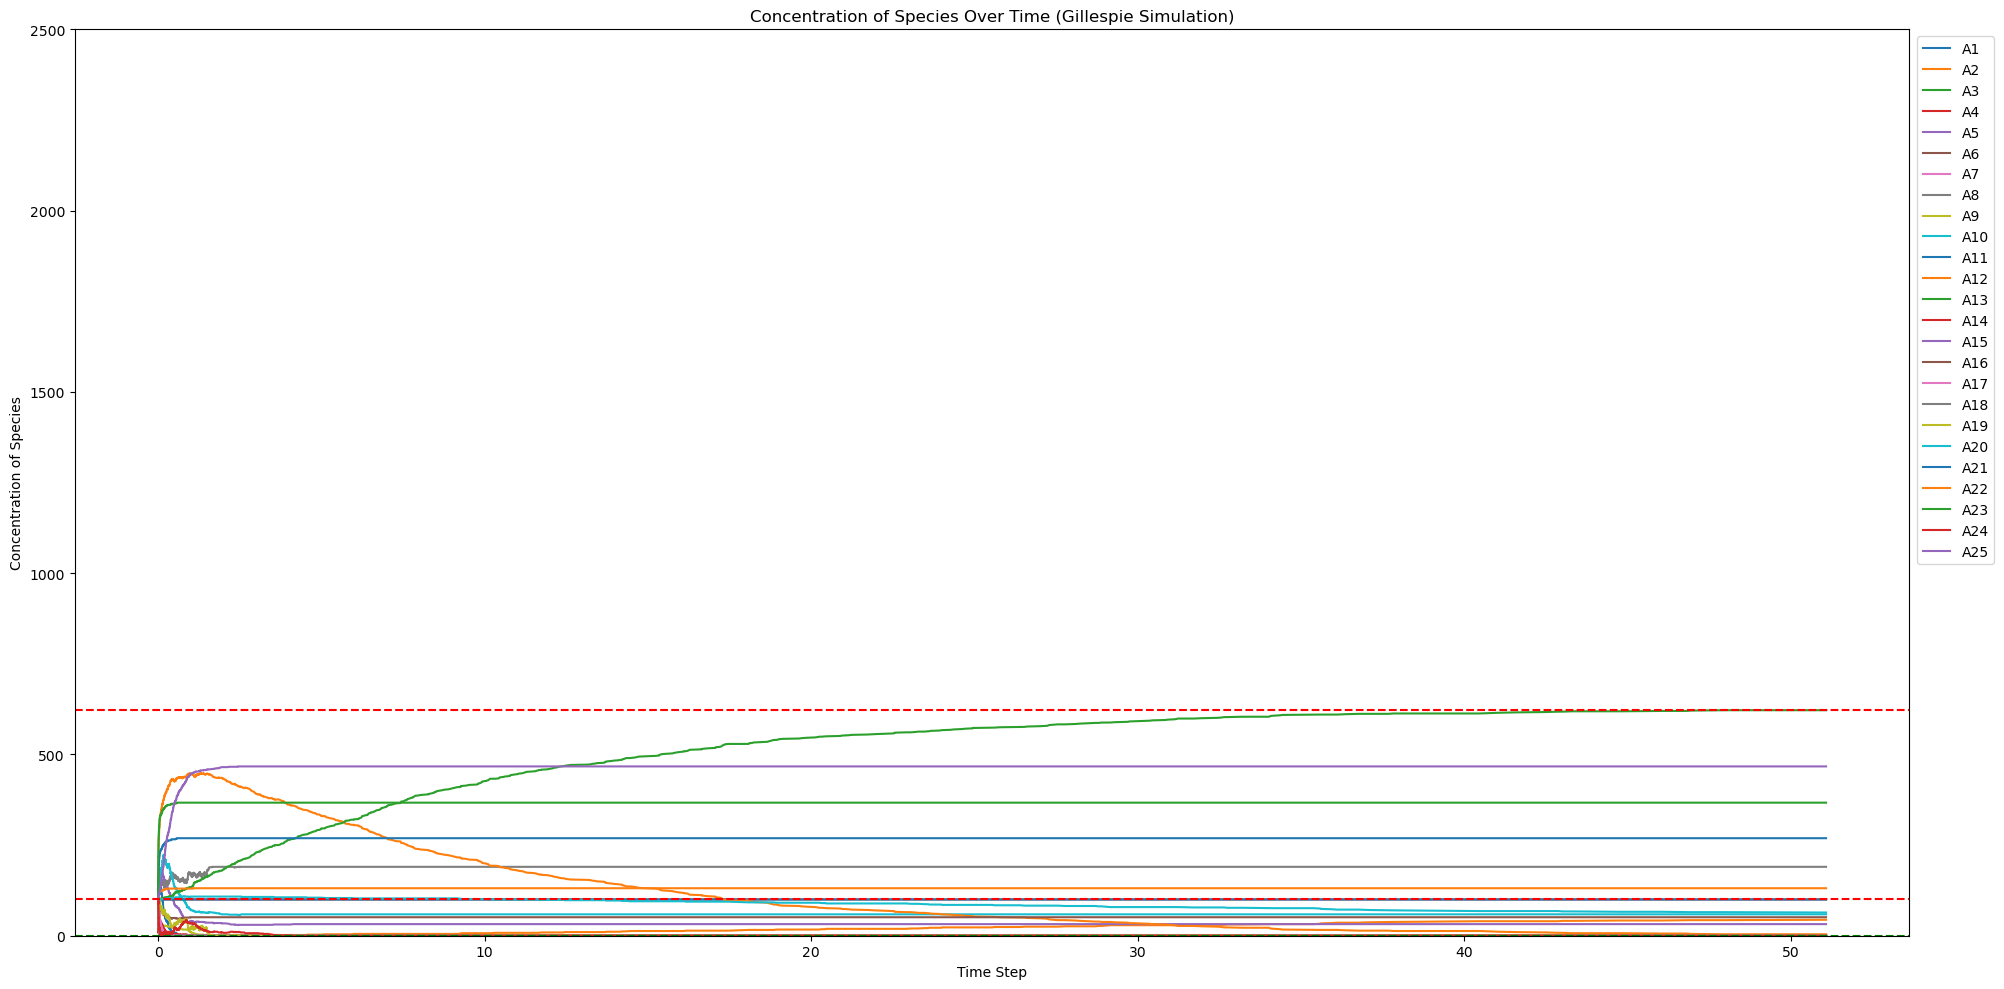

Smallest time_instant to occur :  4.174676648116956e-06


In [27]:
initial_conc = 100
time_step = 50
simulation_with_plot(initial_conc,time_step,25*initial_conc)

(25, 75, 0.3, 0.5, 100)
Number of species :  25 
Number of reactions :  75 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  25
Number of species at minimum concentration : 14
Minimum concentration :  0 of species :  ['A1', 'A5', 'A7', 'A9', 'A10', 'A11', 'A12', 'A16', 'A17', 'A18', 'A19', 'A21', 'A22', 'A25']
Maximum concentration :  1122 of species :  ['A13']
Number of species :  25
Number of species at minimum concentration : 14
Minimum concentration :  0 of species :  ['A1', 'A5', 'A7', 'A9', 'A10', 'A11', 'A12', 'A16', 'A17', 'A18', 'A19', 'A21', 'A22', 'A25']
Maximum concentration :  1122 of species :  ['A13']


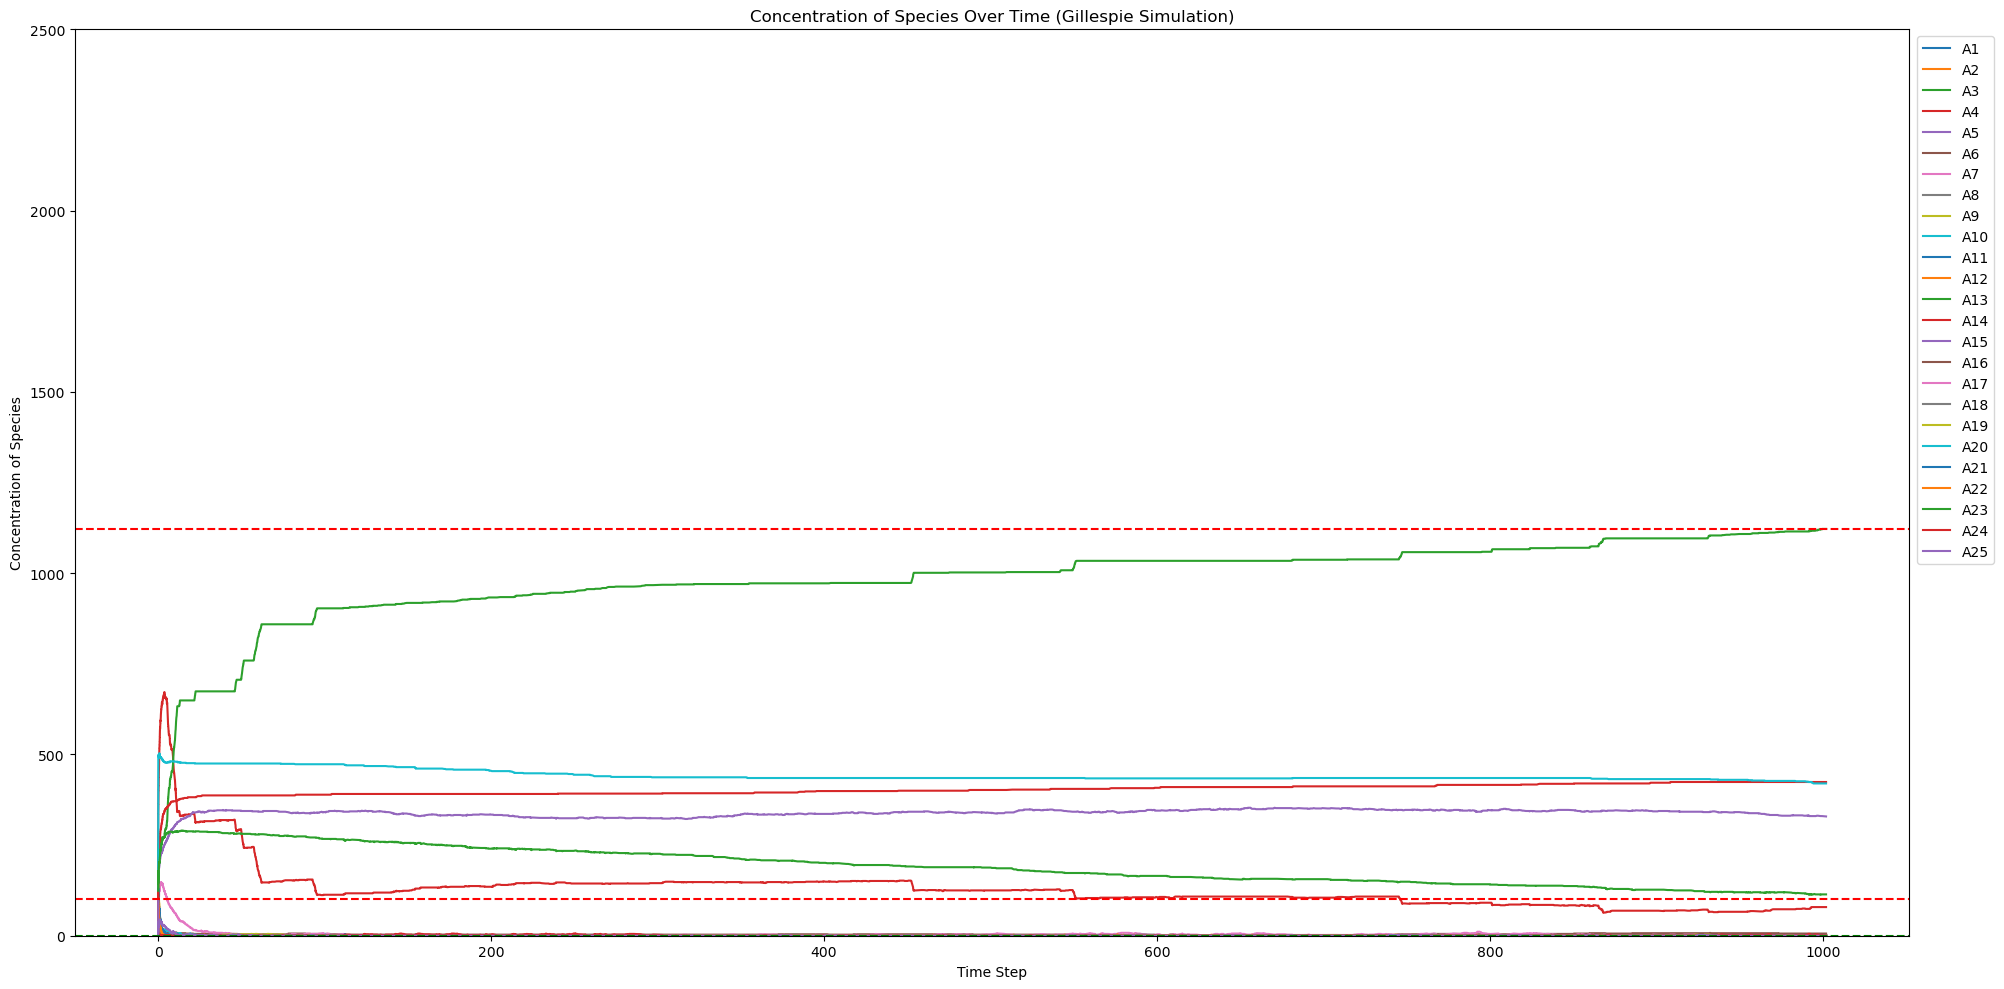

Smallest time_instant to occur :  1.2487155014898034e-09
(25, 100, 0.3, 0.5, 100)
Number of species :  25 
Number of reactions :  100 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  25
Number of species at minimum concentration : 8
Minimum concentration :  0 of species :  ['A4', 'A8', 'A13', 'A14', 'A17', 'A18', 'A21', 'A23']
Maximum concentration :  1972 of species :  ['A6']
Number of species :  25
Number of species at minimum concentration : 8
Minimum concentration :  0 of species :  ['A4', 'A8', 'A13', 'A14', 'A17', 'A18', 'A21', 'A23']
Maximum concentration :  1972 of species :  ['A6']


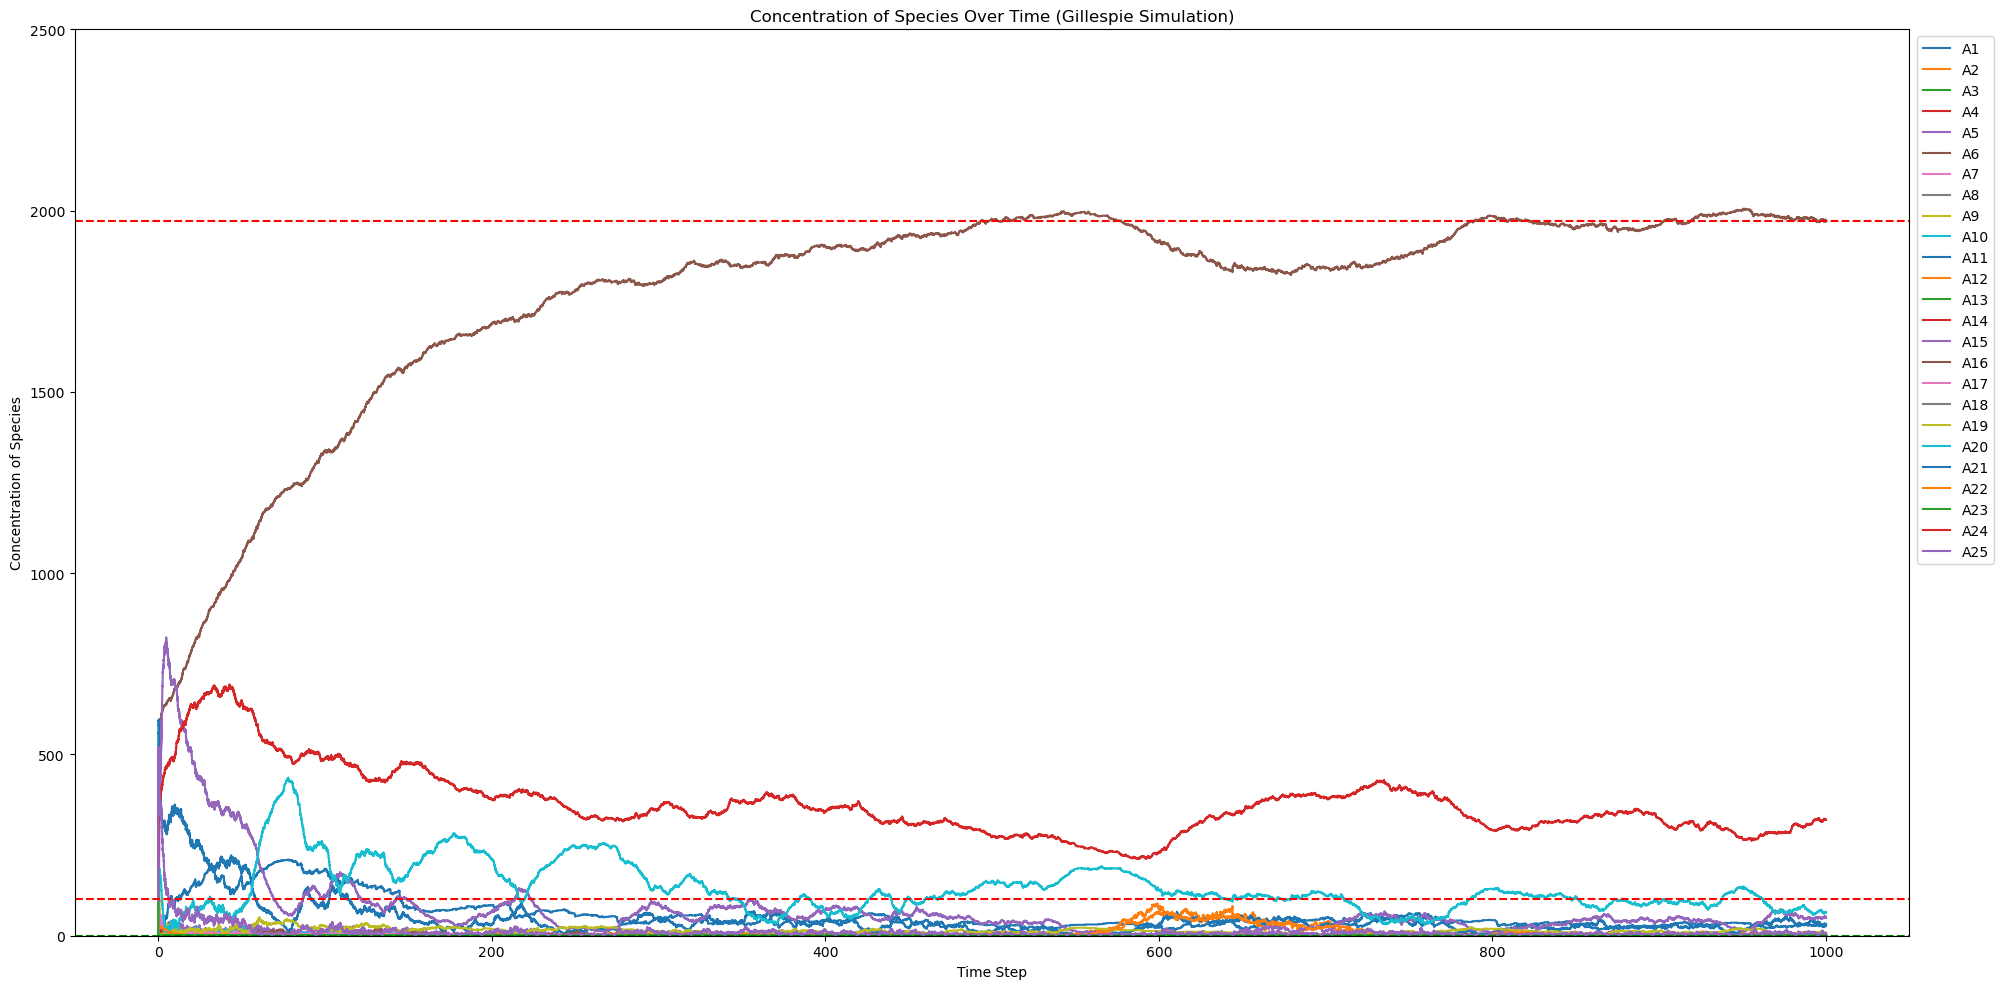

Smallest time_instant to occur :  3.694108795202342e-07
(50, 75, 0.3, 0.5, 100)
Number of species :  50 
Number of reactions :  75 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  50
Number of species at minimum concentration : 31
Minimum concentration :  0 of species :  ['A1', 'A2', 'A4', 'A5', 'A8', 'A11', 'A12', 'A13', 'A14', 'A16', 'A18', 'A19', 'A21', 'A22', 'A24', 'A26', 'A28', 'A29', 'A32', 'A33', 'A34', 'A35', 'A36', 'A38', 'A41', 'A42', 'A44', 'A45', 'A46', 'A48', 'A50']
Maximum concentration :  560 of species :  ['A25']
Number of species :  50
Number of species at minimum concentration : 31
Minimum concentration :  0 of species :  ['A1', 'A2', 'A4', 'A5', 'A8', 'A11', 'A12', 'A13', 'A14', 'A16', 'A18', 'A19', 'A21', 'A22', 'A24', 'A26', 'A28', 'A29', 'A32', 'A33', 'A34', 'A35', 'A36', 'A38', 'A41', 'A42', 'A44', 'A45', 'A46', 'A48', 'A50']
Maximum concentration :  560 of species :  ['A25']


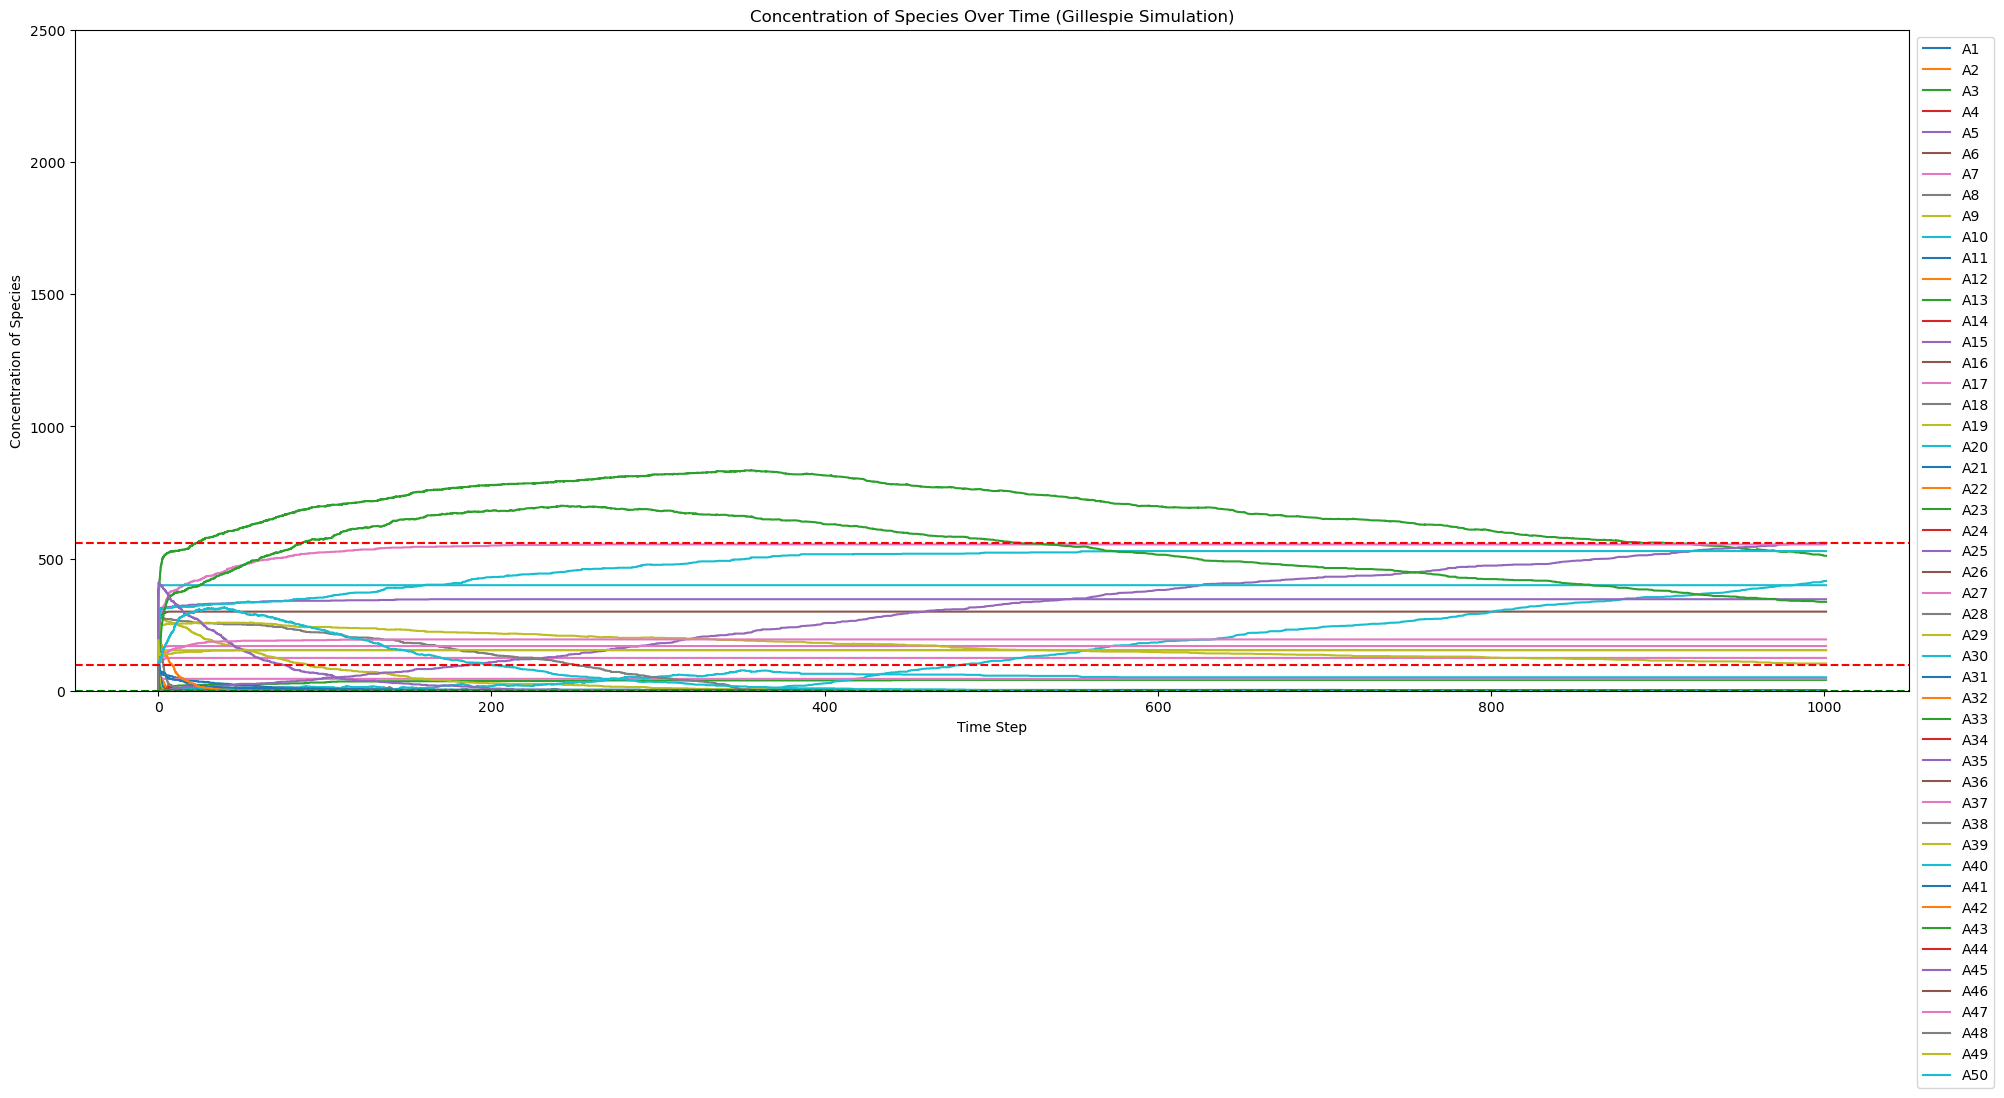

Smallest time_instant to occur :  2.8276752261853675e-07
(50, 100, 0.3, 0.5, 100)
Number of species :  50 
Number of reactions :  100 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  50
Number of species at minimum concentration : 27
Minimum concentration :  0 of species :  ['A1', 'A2', 'A4', 'A6', 'A7', 'A8', 'A9', 'A14', 'A15', 'A17', 'A18', 'A20', 'A21', 'A23', 'A26', 'A27', 'A28', 'A30', 'A31', 'A33', 'A35', 'A38', 'A40', 'A42', 'A43', 'A45', 'A50']
Maximum concentration :  1098 of species :  ['A22']
Number of species :  50
Number of species at minimum concentration : 27
Minimum concentration :  0 of species :  ['A1', 'A2', 'A4', 'A6', 'A7', 'A8', 'A9', 'A14', 'A15', 'A17', 'A18', 'A20', 'A21', 'A23', 'A26', 'A27', 'A28', 'A30', 'A31', 'A33', 'A35', 'A38', 'A40', 'A42', 'A43', 'A45', 'A50']
Maximum concentration :  1098 of species :  ['A22']


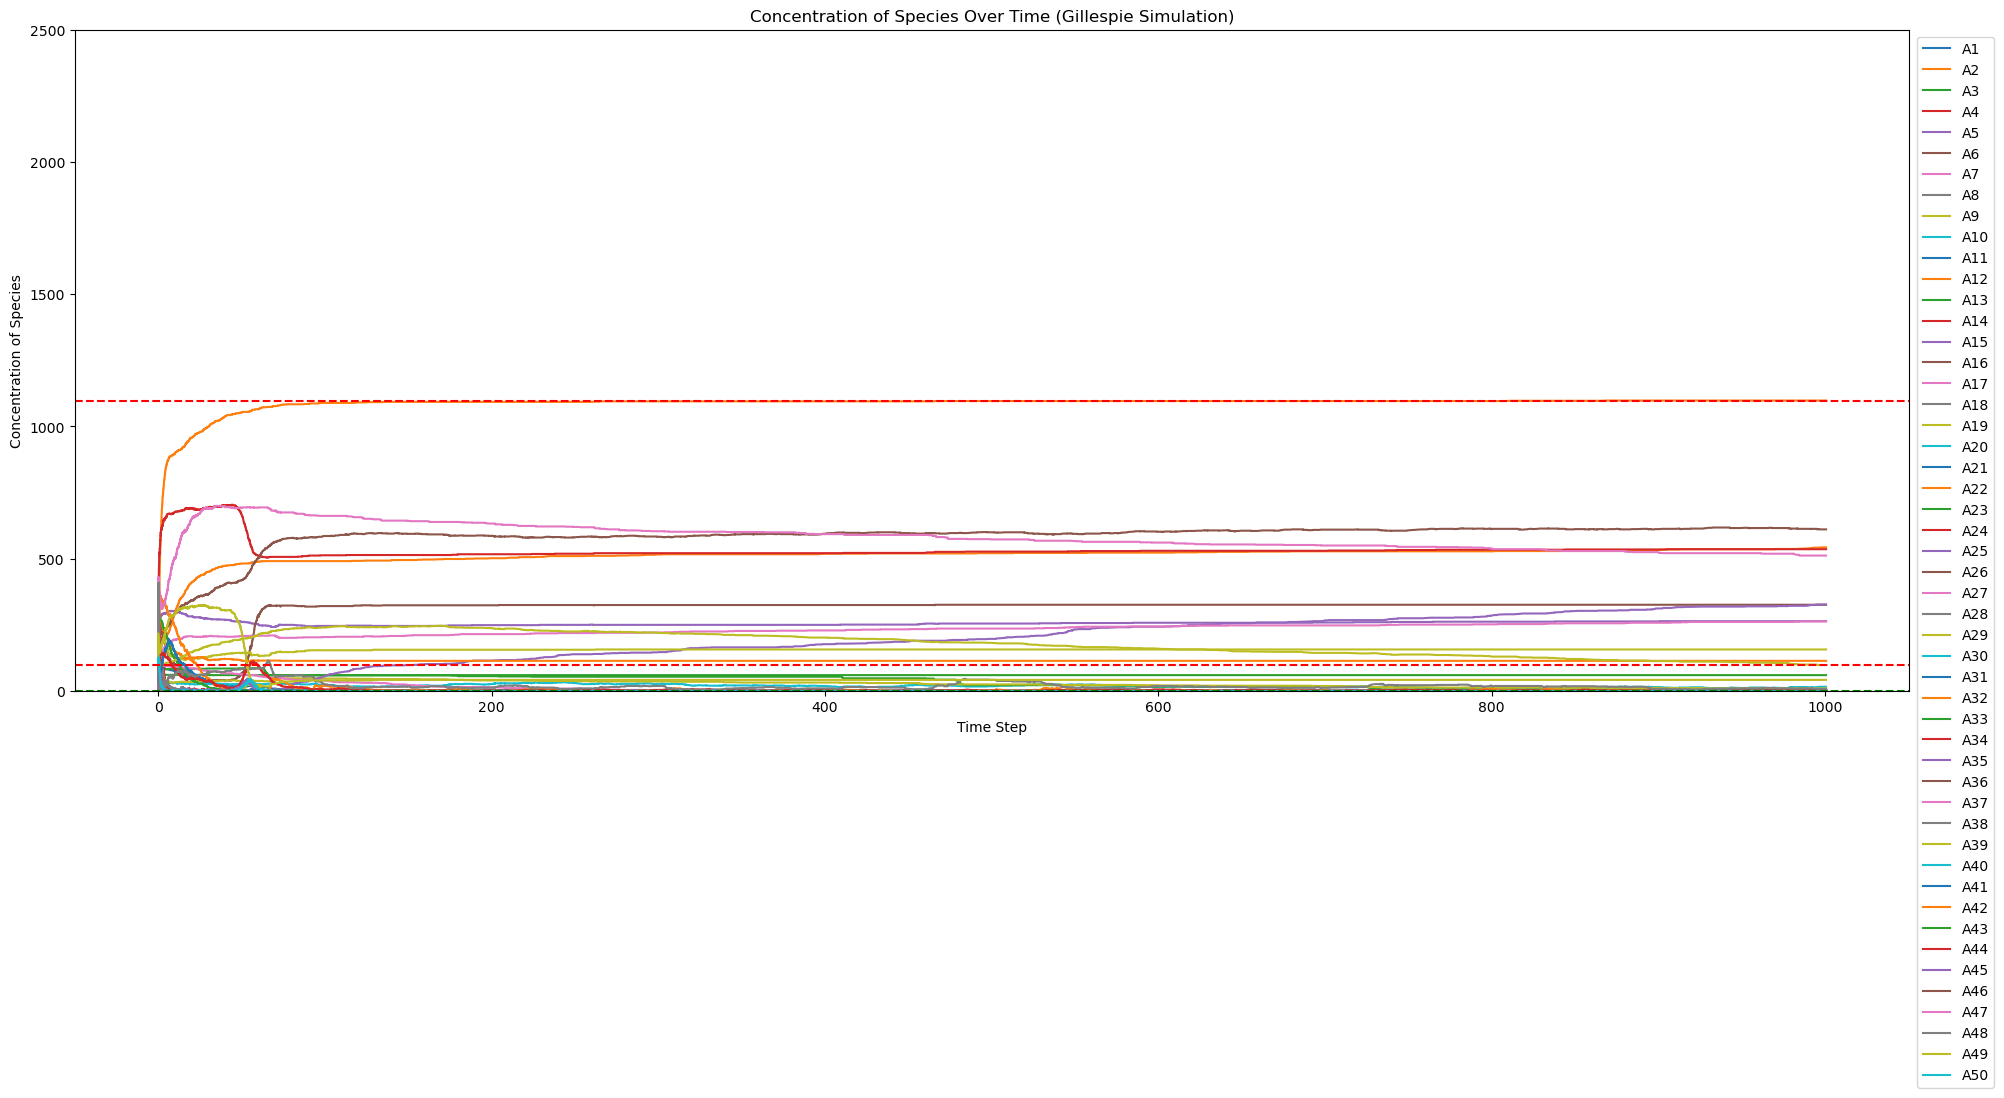

Smallest time_instant to occur :  1.0572114395804269e-07
(75, 75, 0.3, 0.5, 100)
Number of species :  75 
Number of reactions :  75 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  75
Number of species at minimum concentration : 37
Minimum concentration :  0 of species :  ['A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'A14', 'A17', 'A21', 'A23', 'A24', 'A28', 'A29', 'A32', 'A33', 'A34', 'A36', 'A41', 'A43', 'A45', 'A46', 'A47', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A58', 'A59', 'A61', 'A65', 'A69', 'A70', 'A72', 'A73']
Maximum concentration :  954 of species :  ['A68']
Number of species :  75
Number of species at minimum concentration : 37
Minimum concentration :  0 of species :  ['A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'A14', 'A17', 'A21', 'A23', 'A24', 'A28', 'A29', 'A32', 'A33', 'A34', 'A36', 'A41', 'A43', 'A45', 'A46', 'A47', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A58', 'A59', 'A61', 'A65', 'A69', 'A70', 'A72', 'A73']
Maximum 

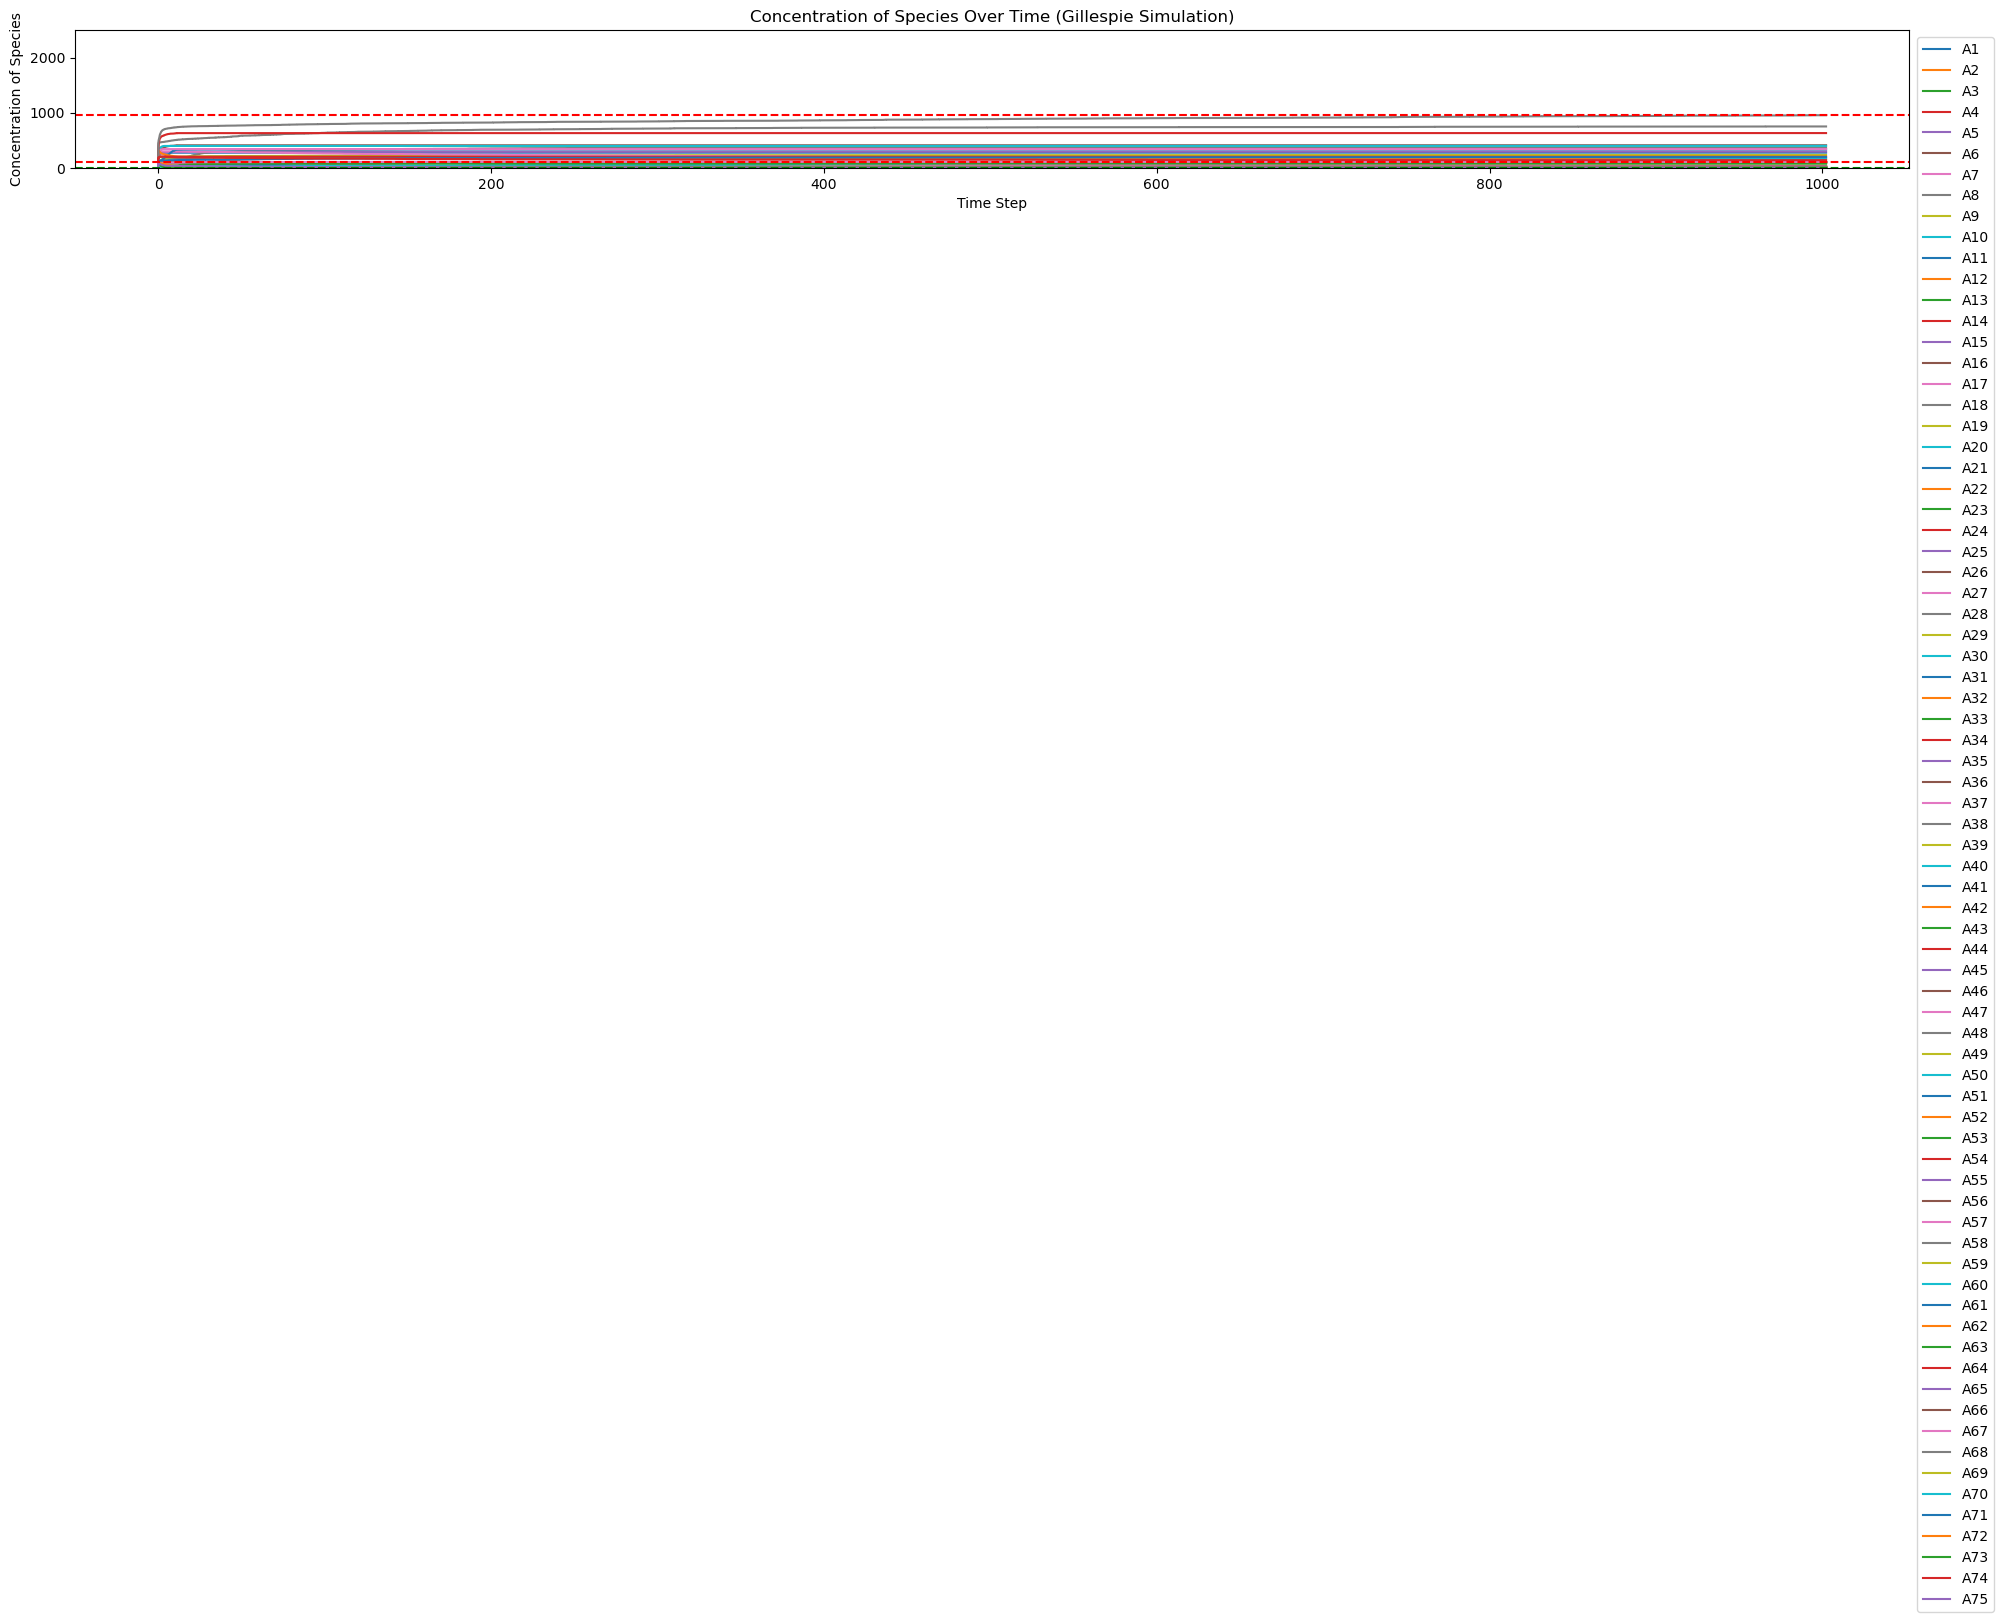

Smallest time_instant to occur :  1.086971174924967e-07
(75, 100, 0.3, 0.5, 100)
Number of species :  75 
Number of reactions :  100 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  75
Number of species at minimum concentration : 43
Minimum concentration :  0 of species :  ['A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A20', 'A24', 'A26', 'A28', 'A30', 'A31', 'A35', 'A36', 'A38', 'A39', 'A40', 'A41', 'A44', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A60', 'A63', 'A64', 'A66', 'A69', 'A70', 'A71', 'A74', 'A75']
Maximum concentration :  1294 of species :  ['A43']
Number of species :  75
Number of species at minimum concentration : 43
Minimum concentration :  0 of species :  ['A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A20', 'A24', 'A26', 'A28', 'A30', 'A31', 'A35', 'A36', 'A38', 'A39', 'A40', 'A41', 'A44', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A53', 'A54', 'A55', 'A56', 'A57', 

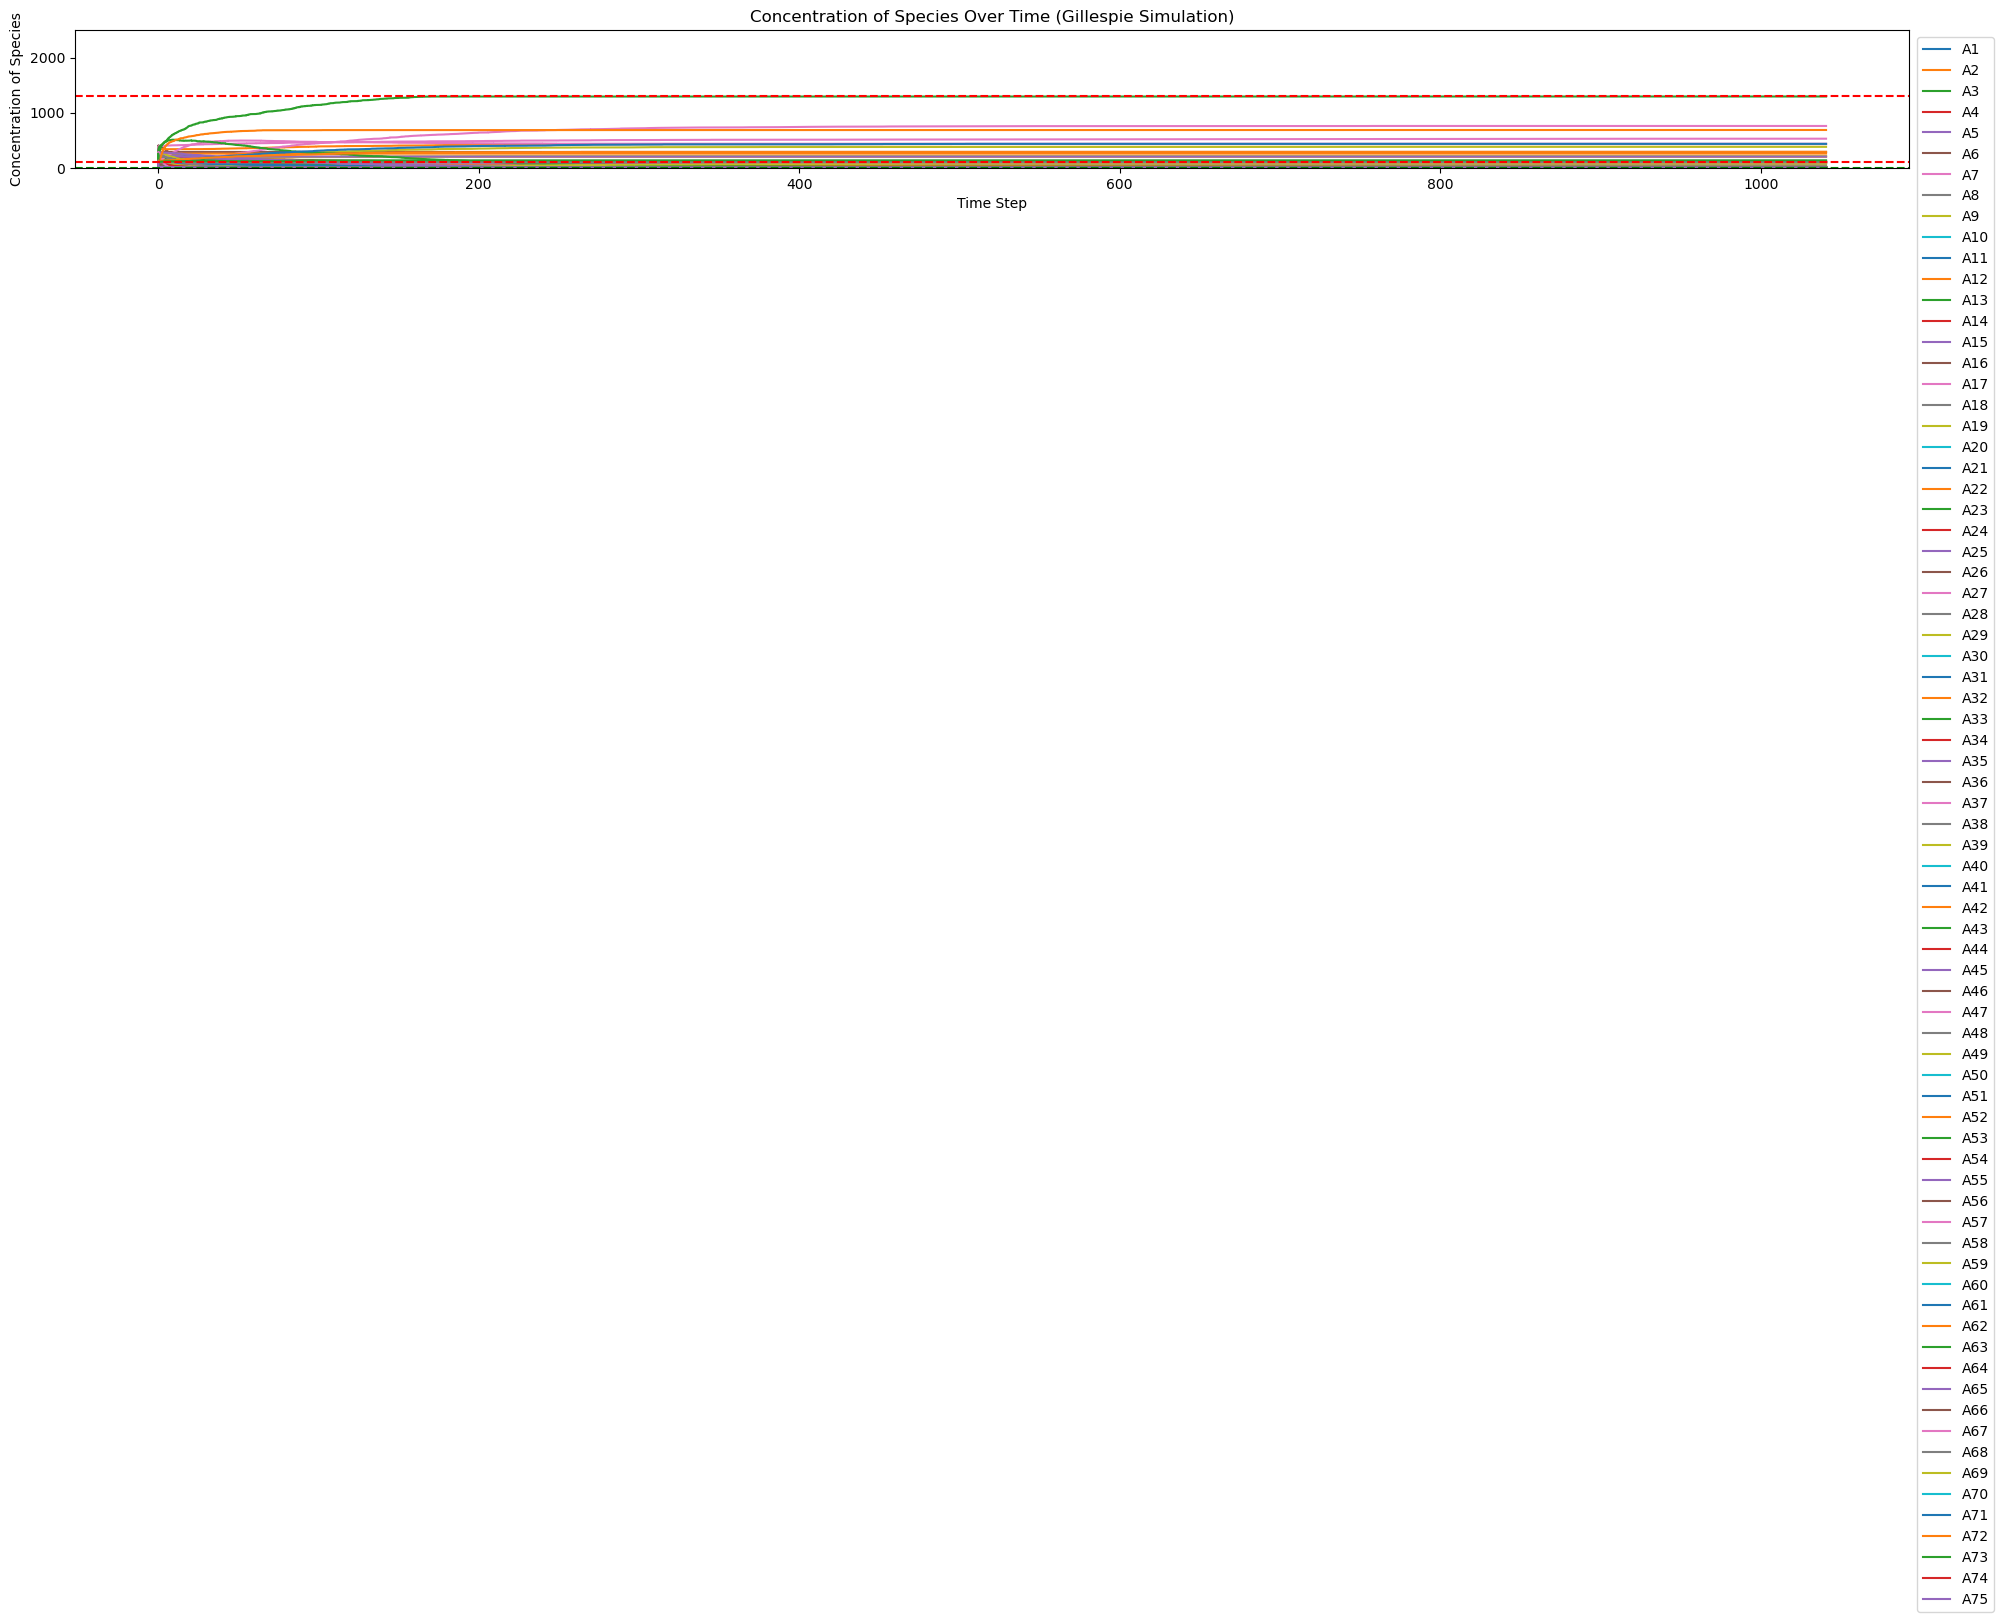

Smallest time_instant to occur :  8.646344745813243e-07
(100, 75, 0.3, 0.5, 100)
Number of species :  100 
Number of reactions :  75 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  100
Number of species at minimum concentration : 38
Minimum concentration :  0 of species :  ['A3', 'A4', 'A7', 'A8', 'A9', 'A11', 'A12', 'A14', 'A17', 'A18', 'A22', 'A26', 'A27', 'A29', 'A30', 'A34', 'A35', 'A38', 'A43', 'A45', 'A49', 'A50', 'A53', 'A57', 'A60', 'A61', 'A64', 'A75', 'A77', 'A78', 'A79', 'A80', 'A85', 'A90', 'A94', 'A96', 'A99', 'A100']
Maximum concentration :  615 of species :  ['A25']
Number of species :  100
Number of species at minimum concentration : 38
Minimum concentration :  0 of species :  ['A3', 'A4', 'A7', 'A8', 'A9', 'A11', 'A12', 'A14', 'A17', 'A18', 'A22', 'A26', 'A27', 'A29', 'A30', 'A34', 'A35', 'A38', 'A43', 'A45', 'A49', 'A50', 'A53', 'A57', 'A60', 'A61', 'A64', 'A75', 'A77', 'A78', 'A79', 'A80', 'A85', 'A90', 'A94', 'A96', 'A99', '

/tmp/ipykernel_6586/2324950620.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to avoid clipping the legend


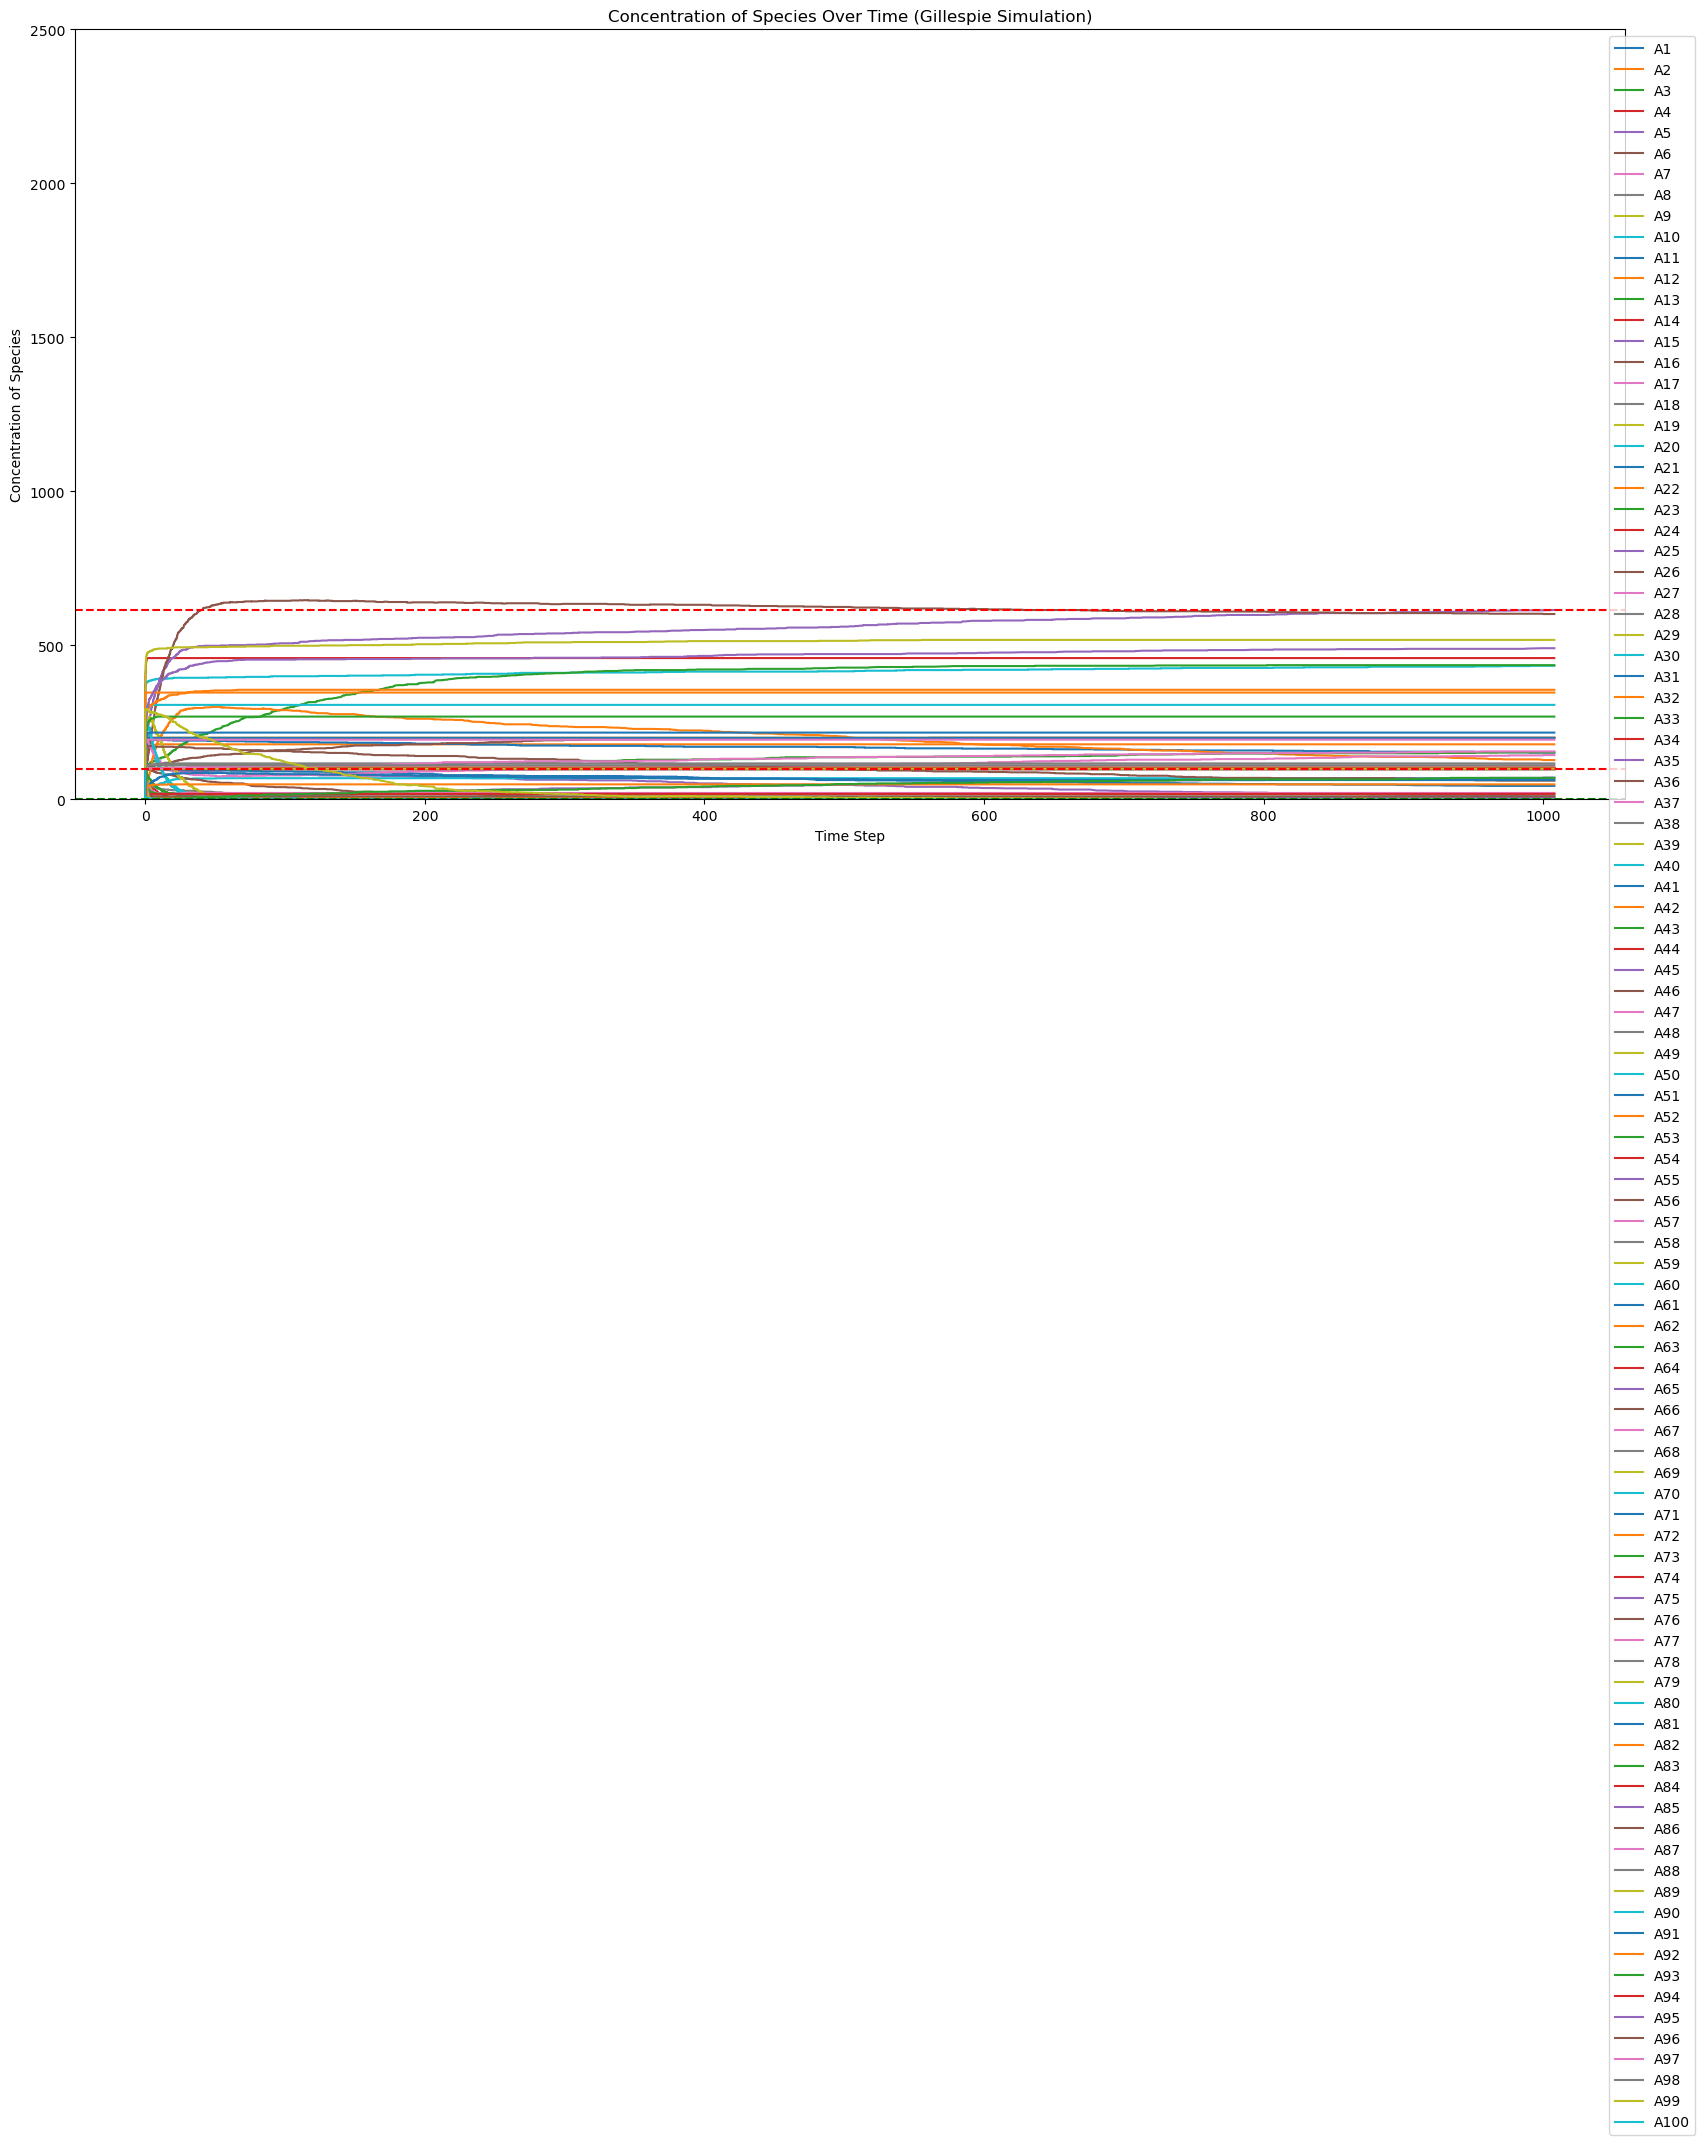

Smallest time_instant to occur :  2.9702410620401794e-09
(100, 100, 0.3, 0.5, 100)
Number of species :  100 
Number of reactions :  100 
p =  0.3 
e =  0.5 
Initial conc =  100
Initial concentration : 100
Number of species :  100
Number of species at minimum concentration : 43
Minimum concentration :  0 of species :  ['A1', 'A3', 'A6', 'A7', 'A13', 'A17', 'A18', 'A19', 'A20', 'A22', 'A24', 'A25', 'A27', 'A35', 'A36', 'A39', 'A42', 'A45', 'A47', 'A51', 'A52', 'A59', 'A65', 'A68', 'A69', 'A71', 'A73', 'A74', 'A77', 'A81', 'A82', 'A85', 'A86', 'A87', 'A88', 'A89', 'A91', 'A93', 'A94', 'A95', 'A96', 'A98', 'A99']
Maximum concentration :  637 of species :  ['A83']
Number of species :  100
Number of species at minimum concentration : 43
Minimum concentration :  0 of species :  ['A1', 'A3', 'A6', 'A7', 'A13', 'A17', 'A18', 'A19', 'A20', 'A22', 'A24', 'A25', 'A27', 'A35', 'A36', 'A39', 'A42', 'A45', 'A47', 'A51', 'A52', 'A59', 'A65', 'A68', 'A69', 'A71', 'A73', 'A74', 'A77', 'A81', 'A82', 'A85

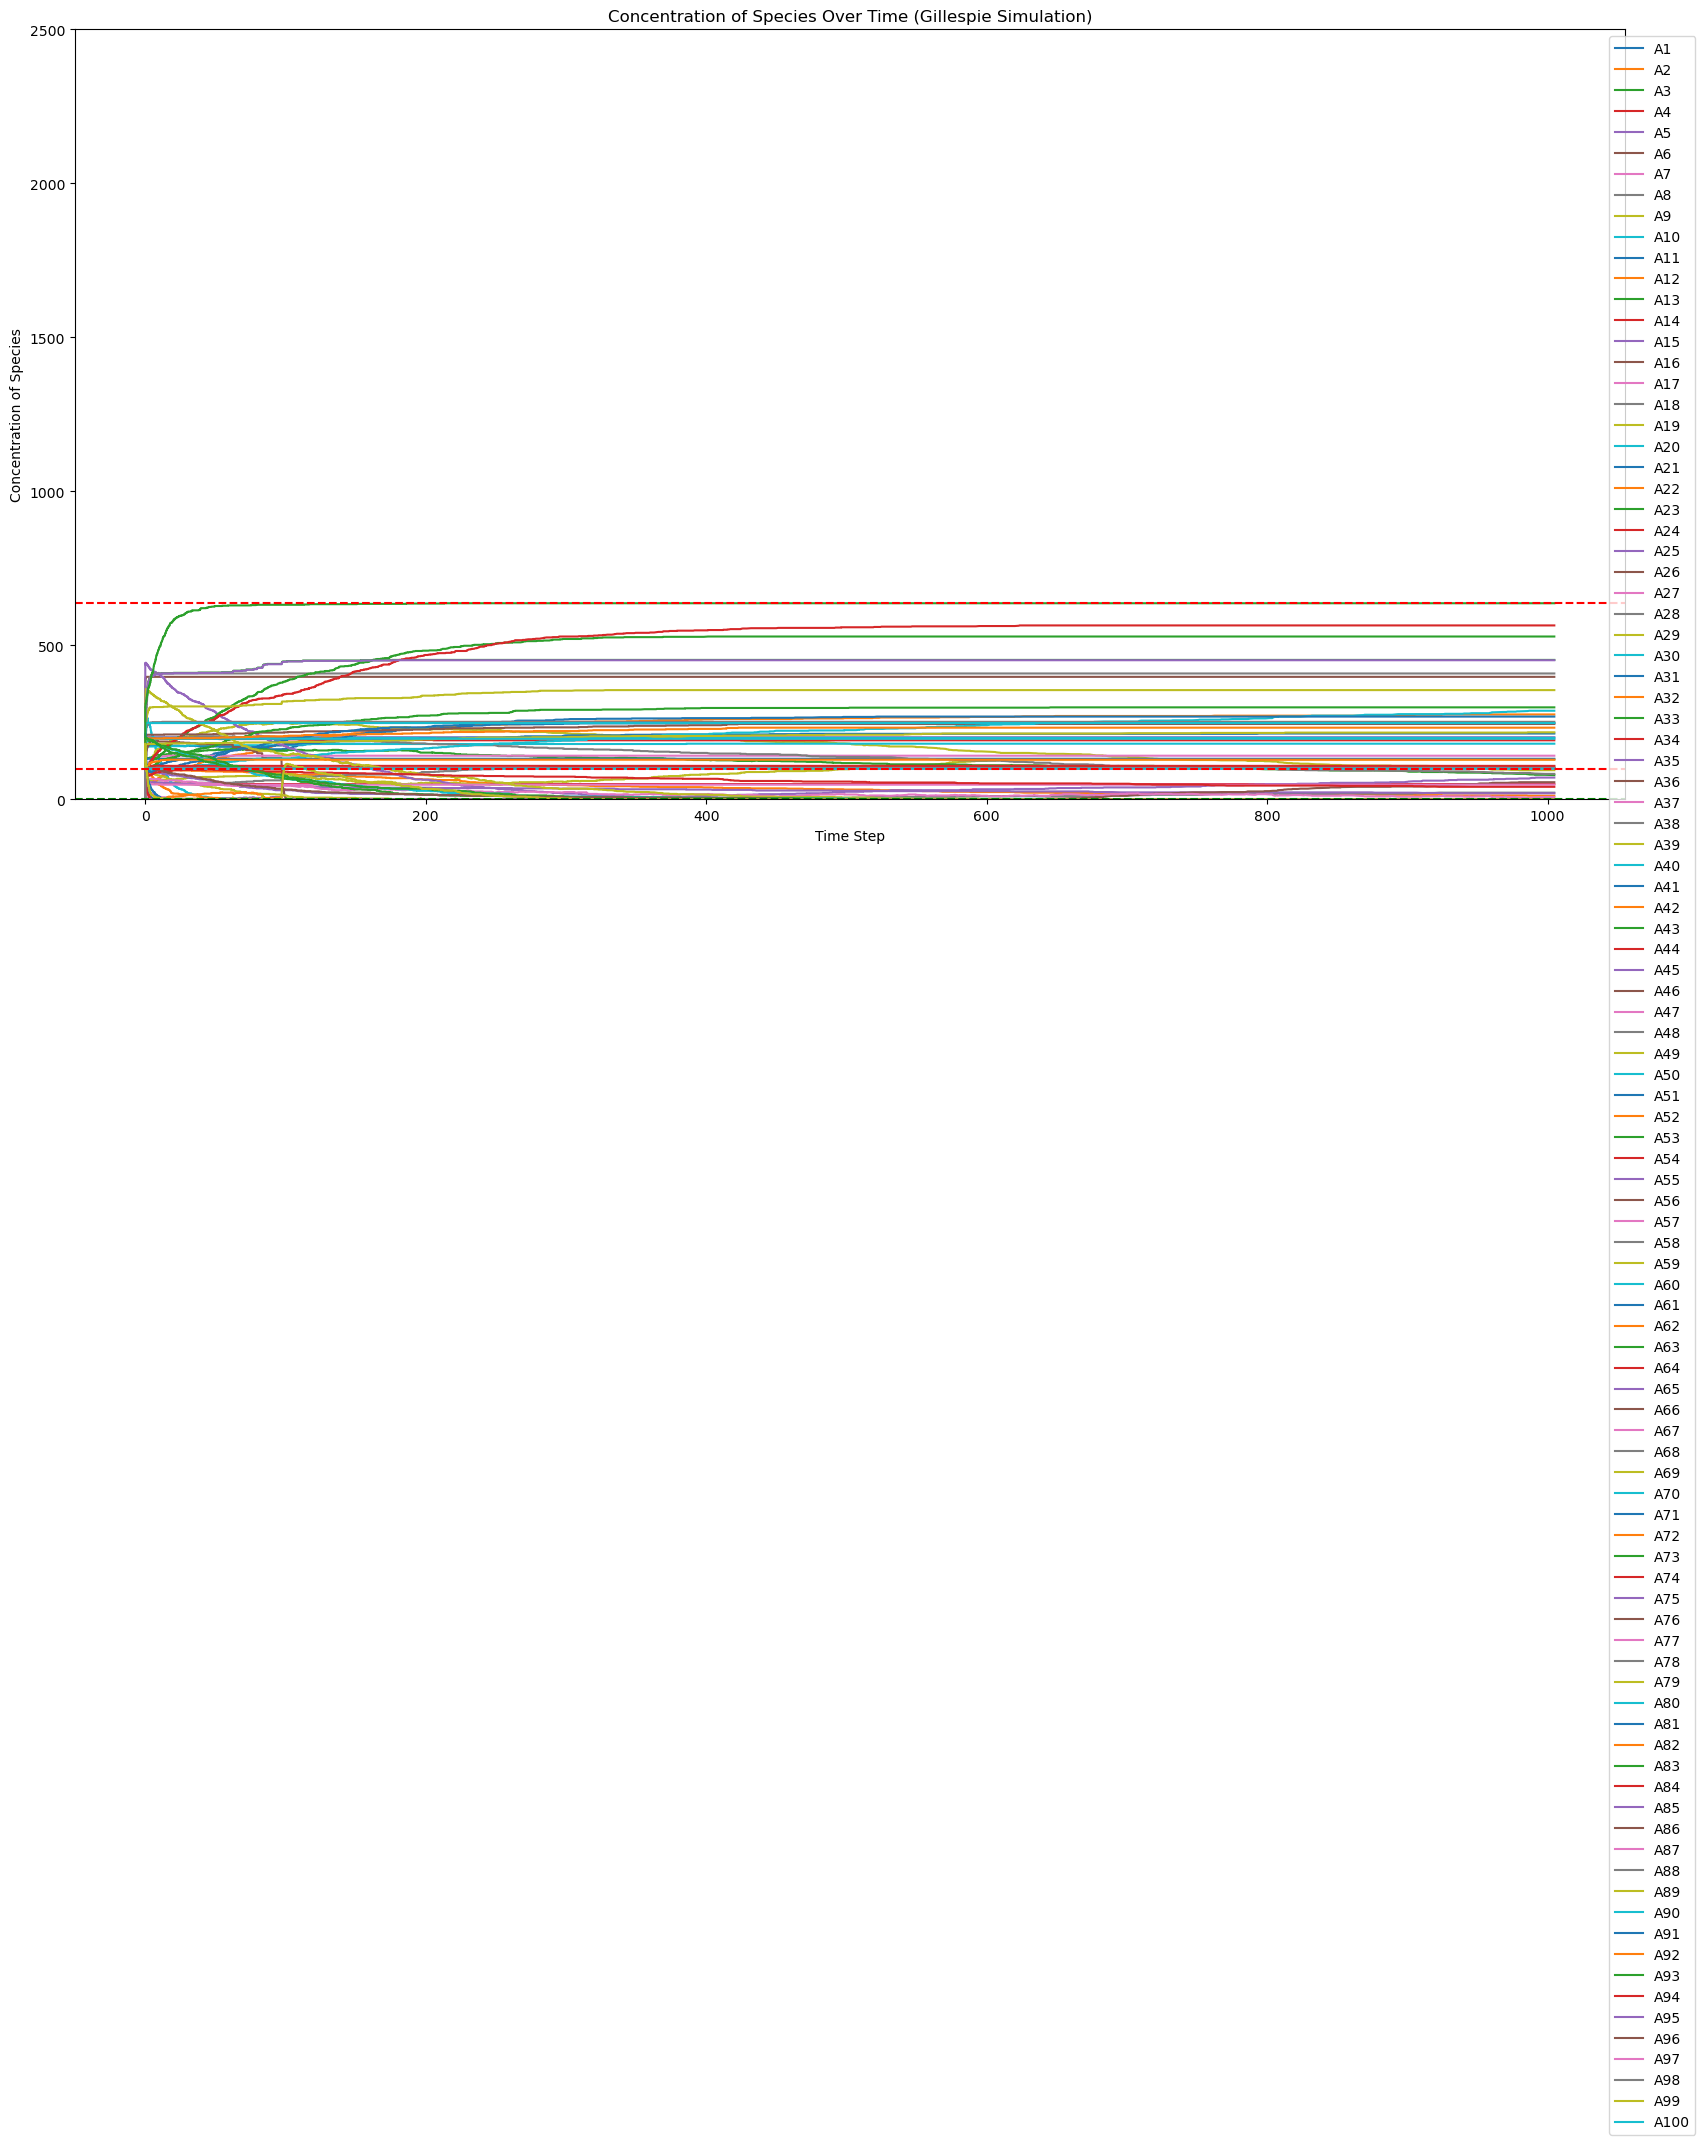

Smallest time_instant to occur :  2.1616398295049259e-07


In [28]:
N = [25,50, 75, 100]
M = [75,100]
p = [0.3]
e = [0.5]
initial_conc = [100]

time_step = 1000

species_concentration_over_multiple_simulations = {}
for i in range(0,len(N)):
    species_concentration_over_multiple_simulations[N[i]] = []
for combination in itertools.product(N,M,p,e,initial_conc):
    print(combination)
    print("Number of species : ",combination[0], "\nNumber of reactions : ", combination[1], "\np = ",combination[2], "\ne = ",combination[3], "\nInitial conc = ",combination[4])
    n,m,P,E,IC = combination
    species, reactions = create_network(n,m,rate_constants,P,E)
    # steady_state_concentrations = simulation_without_plot(IC, time_step, 10*IC)
    simulation_with_plot(IC,time_step, 25*IC)

# MTD